# Plug in SimPEG's gravity simulation into the new framework

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
from gravity import GravitySimulation
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200]) # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(
    coordinates,
    prisms,
    densities,
    field="g_z"
)
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


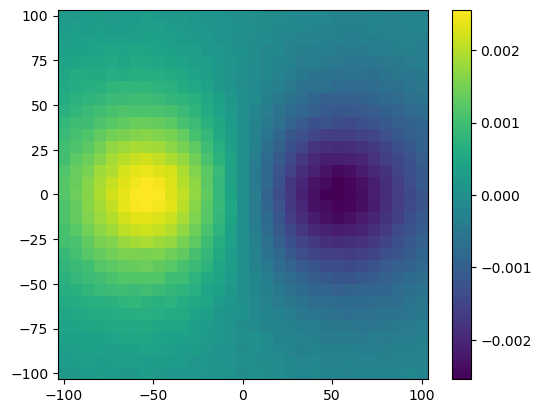

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
h = [(5.0, 40)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 64,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     40       -100.00        100.00      5.00      5.00    1.00
   y     40       -100.00        100.00      5.00      5.00    1.00
   z     40       -200.00          0.00      5.00      5.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7febc8201e50>,)

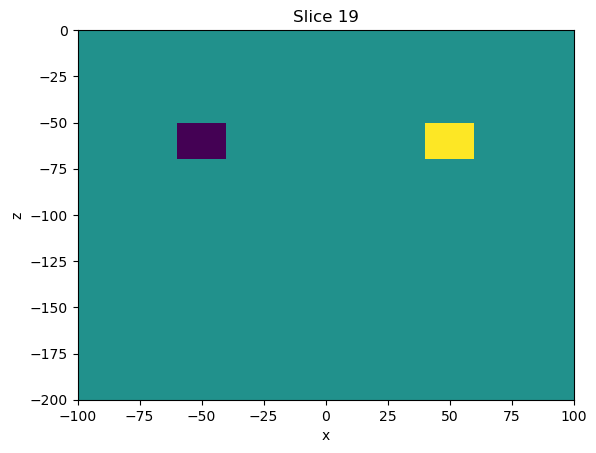

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

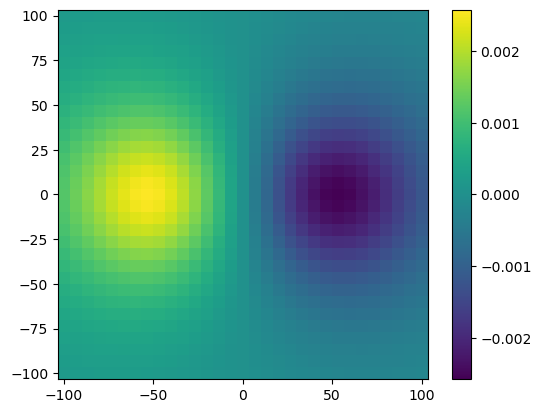

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Define (simple) inversion using the new framework

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = GravitySimulation(simulation_simpeg)

In [15]:
dpred = simulation(model)

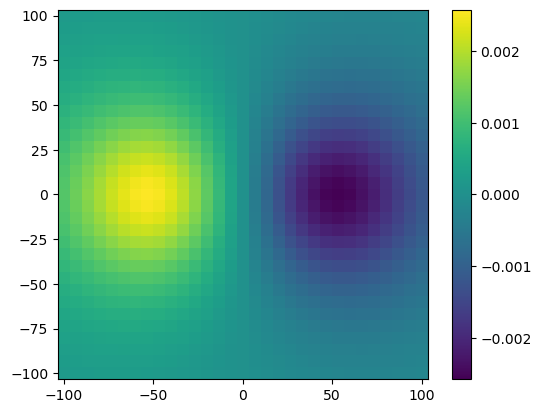

In [16]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [17]:
simulation.jacobian(model)

<961x64000 _CustomLinearOperator with dtype=float64>

In [18]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [19]:
volume_weights = mesh.cell_volumes
depth_weights = depth_weighting(mesh, 0)
smallness = ii.TikhonovZero(
    n_params=simulation.n_params, weights=volume_weights * depth_weights
)

In [20]:
phi = data_misfit + 1e2 * smallness

In [21]:
minimizer = ii.ConjugateGradient()

In [22]:
initial_model = np.zeros(simulation.n_params)
inverted_model = minimizer(phi, initial_model)

In [23]:
inverted_model

array([-0.00016457, -0.00016604, -0.00016616, ..., -0.00027763,
        0.0003595 , -0.00030917], shape=(64000,))

(<matplotlib.collections.QuadMesh at 0x7febca2d7c50>,)

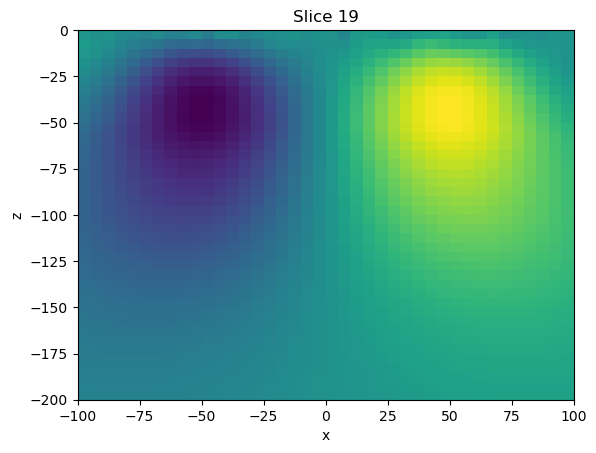

In [24]:
mesh.plot_slice(inverted_model, normal="Y", slice_loc=0)

## Run inversion with beta cooling

In [25]:
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

phi

φd(m) + 1.00e+04 φs(m)

In [26]:
# Initial model
initial_model = np.zeros(simulation.n_params)

# Minimizer
minimizer = ii.ConjugateGradient()

# Stopping criteria
chi_target = 1.0
stopping_criteria = ii.ChiTarget(data_misfit, chi_target=chi_target)

# Beta cooling
beta_cooler = ii.MultiplierCooler(regularization, cooling_factor=2.0)

# Inversion log
inversion_log = ii.create_standard_log(phi)
inversion_log.columns["chi_target hit?"] = lambda _, model: stopping_criteria(model)

# Inversion
inversion = ii.Inversion(
    phi,
    initial_model,
    minimizer,
    directives=[beta_cooler],
    stopping_criteria=stopping_criteria,
    cache_models=True,
    log=inversion_log,
)

In [27]:
with inversion.log.show_live() as live:
    for model in inversion:
        # Refresh table
        live.refresh()

Output()

In [28]:
log = pd.DataFrame(inversion.log.log).set_index("iter")
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,chi_target hit?
iter,,,,,,,
0,10000.0,1.667546e+06,0.000000,0.000000,1.667546e+06,1735.219131,False
1,10000.0,9.161868e+03,6.949686,69496.858921,7.865873e+04,9.533682,False
2,5000.0,3.426773e+03,7.728977,38644.884162,4.207166e+04,3.565841,False
3,2500.0,1.441418e+03,8.268061,20670.152010,2.211157e+04,1.499915,False
4,1250.0,7.126251e+02,8.667543,10834.428659,1.154705e+04,0.741545,True


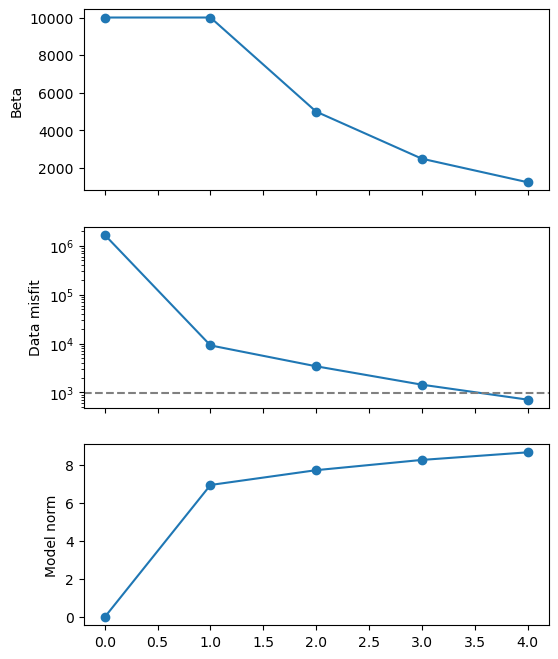

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 8))
axes[0].plot(log.index, log.beta, "o-")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, "o-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, "o-")
axes[2].set_ylabel("Model norm")

plt.show()

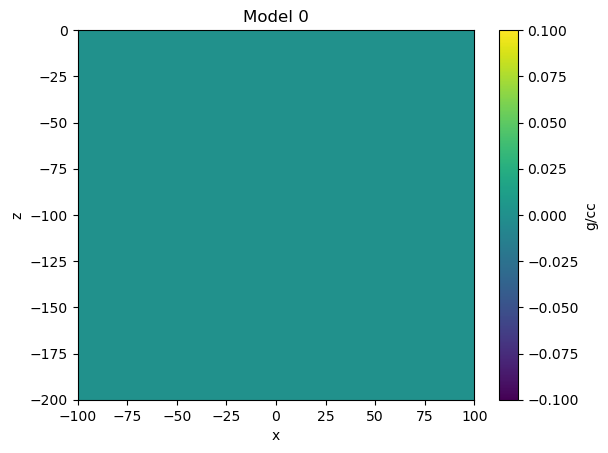

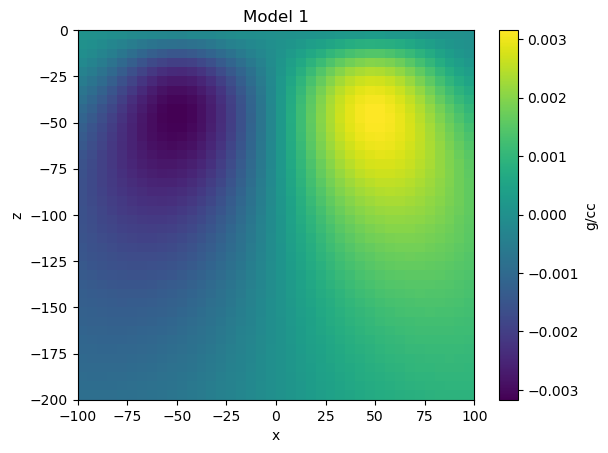

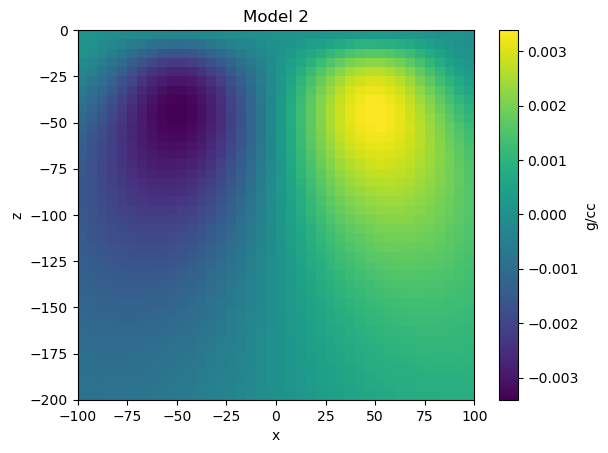

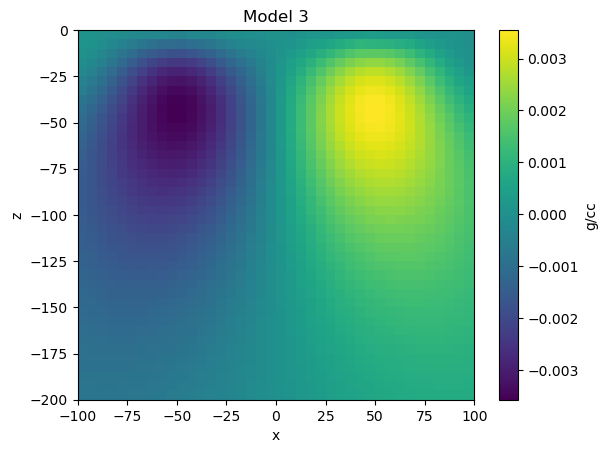

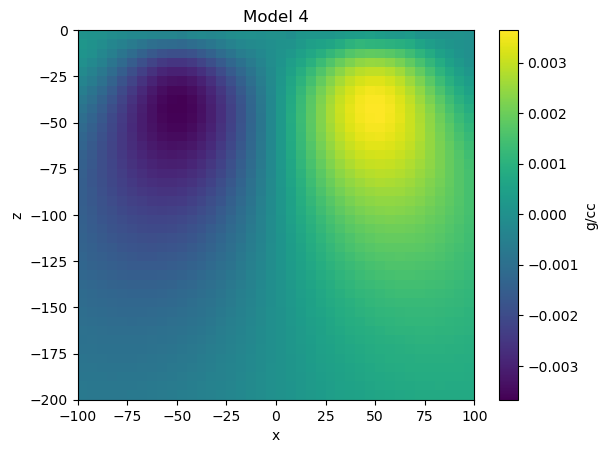

In [30]:
for i, model in enumerate(inversion.models):
    tmp, = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()

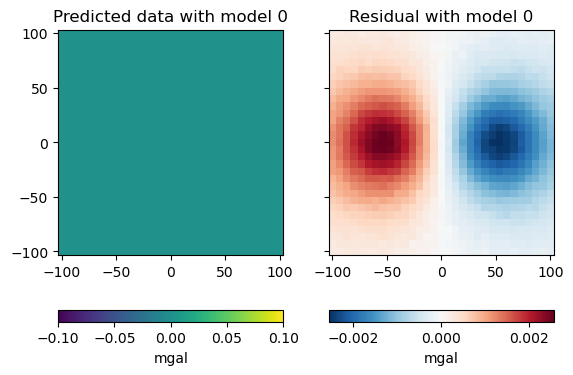

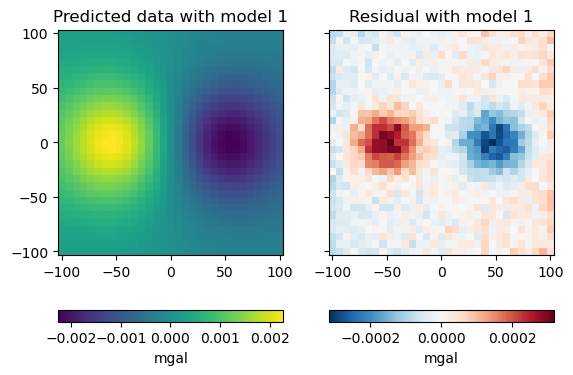

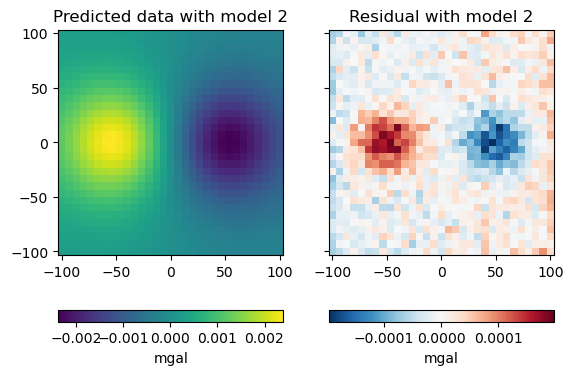

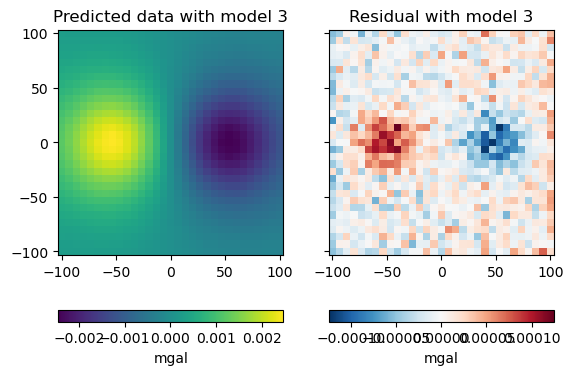

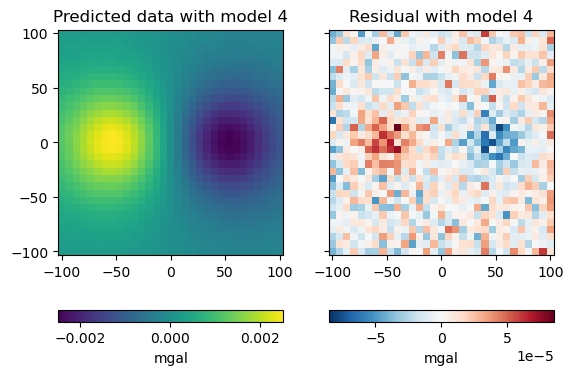

In [31]:
for i, model in enumerate(inversion.models):
    dpred = simulation(model).reshape(coordinates[0].shape)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
    tmp = axes[0].pcolormesh(*coordinates[:2], dpred)
    axes[0].set_title(f"Predicted data with model {i}")
    plt.colorbar(tmp, ax=axes[0], orientation="horizontal", label="mgal")

    residual = gz - dpred
    maxabs = vd.maxabs(residual)
    tmp = axes[1].pcolormesh(*coordinates[:2], residual, vmin=-maxabs, vmax=maxabs, cmap="RdBu_r")
    axes[1].set_title(f"Residual with model {i}")
    plt.colorbar(tmp, ax=axes[1], orientation="horizontal", label="mgal")
    
    for ax in axes:
        ax.set_aspect("equal")
    plt.show()